### Original Source Description

This directory contains the Enron-Spam datasets, as described in the 
paper:

V. Metsis, I. Androutsopoulos and G. Paliouras, "Spam Filtering with 
Naive Bayes - Which Naive Bayes?". Proceedings of the 3rd Conference 
on Email and Anti-Spam (CEAS 2006), Mountain View, CA, USA, 2006.

The "preprocessed" subdirectory contains the messages in the 
preprocessed format that was used in the experiments of the paper.
Each message is in a separate text file. The number at the beginning
of each filename is the "order of arrival".

The "raw" subdirectory contains the messages in their original form. 
Spam messages in non-Latin encodings, ham messages sent by the owners 
of the mailboxes to themselves (sender in "To:", "Cc:", or "Bcc" 
field), and a handful of virus-infected messages have been removed, 
but no other modification has been made. The messages in the "raw" 
subdirectory are more than the corresponding messages in the 
"preprocessed" subdirectory, because: (a) duplicates are preserved 
in the "raw" form, and (b) during the preprocessing, ham and/or spam 
messages were randomly subsampled to obtain the desired ham:spam 
ratios. See the paper for further details.

The Enron-Spam datasets are available from: 
<http://www.iit.demokritos.gr/skel/i-config/> and
<http://www.aueb.gr/users/ion/publications.html>.

The paper is available from:
<http://www.ceas.cc/> and 
<http://www.aueb.gr/users/ion/publications.html>.

V. Metsis, I. Androutsopoulos and G. Paliouras  

This file last updated: June 19, 2006.

### Import all necessary libraries

In [184]:
#!pip install seaborn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
import nltk
import sklearn
import nltk.collocations 
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import string, re
import urllib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
#nltk.download('punkt')
#nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dilyankovachev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/dilyankovachev/nltk_data...
[nltk_data]   Package words is already up-to-date!


### 1. Read CSV Data

In [3]:
email_list = pd.read_csv('email_snorkel.csv')
# charts = pd.read_csv('chart.csv')

In [4]:
email_list.head()

,index,subject,content,label
0,0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0
1,1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0
2,17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0
3,35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0
4,49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0


### 2. Perform some initial EDA and Data Cleaning

In [5]:
email_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33717 entries, 0 to 33716
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    33717 non-null  object 
 1   subject  33426 non-null  object 
 2   content  33345 non-null  object 
 3   label    10092 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.0+ MB


In [6]:
email_list.isna().sum()

index          0
subject      291
content      372
label      23625
dtype: int64

In [7]:
email_list.label.value_counts()

1.0    5111
0.0    4981
Name: label, dtype: int64

In [8]:
# Create Dataframe with Non-NULL labels to be used for model training
model_df = email_list[email_list.label.notnull()]

In [9]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10092 entries, 0 to 33716
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    10092 non-null  object 
 1   subject  9999 non-null   object 
 2   content  9988 non-null   object 
 3   label    10092 non-null  float64
dtypes: float64(1), object(3)
memory usage: 394.2+ KB


In [10]:
model_df.isna().sum()

index        0
subject     93
content    104
label        0
dtype: int64

In [11]:
#Drop Rows with NaN values from DF
model_df.dropna(inplace = True)

/var/folders/m5/cpwnjwg9647cn16n2hrhhj_c0000gn/T/ipykernel_18821/4281718077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(inplace = True)


In [12]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 33716
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    9914 non-null   object 
 1   subject  9914 non-null   object 
 2   content  9914 non-null   object 
 3   label    9914 non-null   float64
dtypes: float64(1), object(3)
memory usage: 387.3+ KB


In [13]:
model_df.head()

,index,subject,content,label
0,0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0
1,1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0
2,17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0
3,35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0
4,49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0


In [14]:
model_df.set_index(['index'], inplace = True)

In [15]:
model_df.head()

,subject,content,label
index,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0
35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0
49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0


### 3. Tokenize, remove punctuation and stopwords and Lemmatize / Stem Text

In [16]:
content = list(model_df.content)
subject = list(model_df.subject)

In [17]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
english = list(set(nltk.corpus.words.words()))

In [18]:
#Write Function that tokenizes, cleans and lematizes & stems text data
def clean_docs_lem_stem(text_list):
    cleaned_lem = []
    cleaned_stem = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for text in text_list:
        clean_text = nltk.regexp_tokenize(text, pattern)
        text_lower = [i.lower() for i in clean_text]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        text_tokens_stopped = [w for w in text_lower if not w in stopwords_list]
        text_lemmas = [lemmatizer.lemmatize(word) for word in text_tokens_stopped]
        text_stemmas = [stemmer.stem(word) for word in text_tokens_stopped]
        lemmas = " ".join(text_lemmas)
        stems = " ".join(text_stemmas)
        cleaned_lem.append(lemmas)
        cleaned_stem.append(stems)
    return [cleaned_lem, cleaned_stem]

In [19]:
clean_content = clean_docs_lem_stem(content)
clean_subject = clean_docs_lem_stem(subject)

In [23]:
lemmatized_content = clean_content[0]
lemmatized_subject = clean_subject[0]
stemmed_content = clean_content[1]
stemmed_subject = clean_subject[1]

In [25]:
model_df['content_lem'] = lemmatized_content
model_df['subject_lem'] = lemmatized_subject
model_df['content_stem'] = stemmed_content
model_df['subject_stem'] = stemmed_subject

/var/folders/m5/cpwnjwg9647cn16n2hrhhj_c0000gn/T/ipykernel_18821/3702268125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['content_lem'] = lemmatized_content
/var/folders/m5/cpwnjwg9647cn16n2hrhhj_c0000gn/T/ipykernel_18821/3702268125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['subject_lem'] = lemmatized_subject
/var/folders/m5/cpwnjwg9647cn16n2hrhhj_c0000gn/T/ipykernel_18821/3702268125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [26]:
model_df.head()

,subject,content,label,content_lem,subject_lem,content_stem,subject_stem
index,,,,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,email loading wise triatomic lauren jocular li...,,email load wise triatom lauren jocular lifo pe...,
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,content type text plain charset iso content tr...,lose pound instantly,content type text plain charset iso content tr...,lose pound instant
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,htmlhead headbodycenterfont size face arial hr...,meet woman area want f u c k,htmlhead headbodycenterfont size face arial hr...,meet women area want f u c k
35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0,n http io com please litterbug boyishdetestati...,appeal democrat daily inspection pain,n http io com pleas litterbug boyishdetest cho...,appeal democrat daili inspect pain
49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0,want dropped list reply email copy paste link ...,find fortune real estate,want drop list repli email copi past link brow...,find fortun real estat


### 4. Explore Content and Subject WordFreq for positive label

In [27]:
#Etract only SPAM emails, to do some preliminary WordCount EDA on positive label sample
spam_df = model_df[model_df.label == 1.0]
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4950 entries, 0 to 23692
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subject       4950 non-null   object 
 1   content       4950 non-null   object 
 2   label         4950 non-null   float64
 3   content_lem   4950 non-null   object 
 4   subject_lem   4950 non-null   object 
 5   content_stem  4950 non-null   object 
 6   subject_stem  4950 non-null   object 
dtypes: float64(1), object(6)
memory usage: 309.4+ KB


In [28]:
spam_df.label.value_counts()

1.0    4950
Name: label, dtype: int64

In [57]:
spam_content_lem = [nltk.word_tokenize(content) for content in list(spam_df.content_lem)]
spam_content_lem = list(np.concatenate(spam_content_lem))
spam_subject_lem = [nltk.word_tokenize(content) for content in list(spam_df.subject_lem)]
spam_subject_lem = list(np.concatenate(spam_subject_lem))

In [61]:
spam_content_lem[:5]

['email', 'loading', 'wise', 'triatomic', 'lauren']

In [59]:
spam_subject_lem[:10]

['lose', 'pound', 'instantly', 'meet', 'woman', 'area', 'want', 'f', 'u', 'c']

In [63]:
spam_content_lem_word_count = FreqDist(spam_content_lem)
spam_subject_lem_word_count = FreqDist(spam_subject_lem)

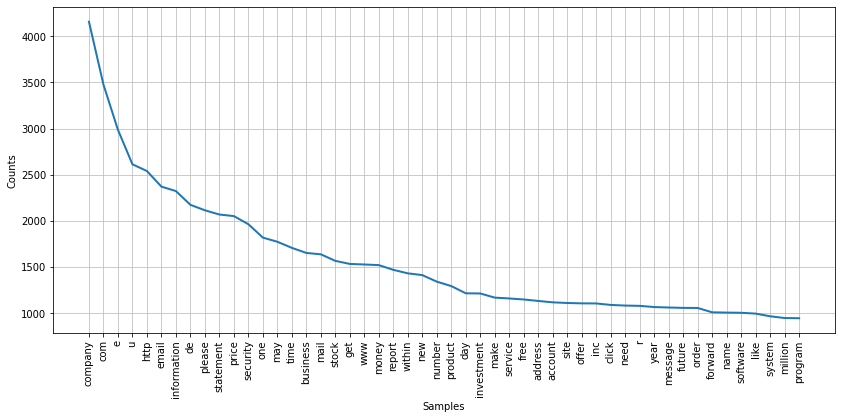

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [75]:
spam_content_lem_word_count.plot(50)

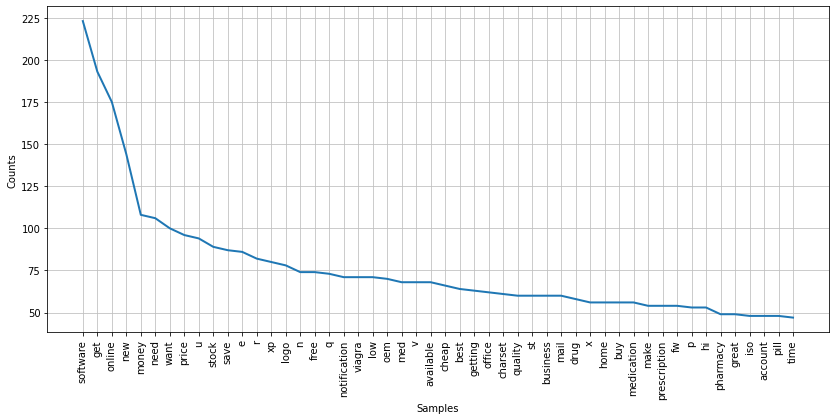

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [76]:
spam_subject_lem_word_count.plot(50)

In [64]:
cont_freq_norm = [(item[0], item[1] / len(spam_content_lem_word_count)) for item in spam_content_lem_word_count.items()]
subj_freq_norm = [(item[0], item[1] / len(spam_subject_lem_word_count)) for item in spam_subject_lem_word_count.items()]

In [65]:
cont_freq_norm[:5]

[('email', 0.03964367489512476),
 ('loading', 0.0006852405862985309),
 ('wise', 0.0003342637006334297),
 ('triatomic', 3.3426370063342974e-05),
 ('lauren', 5.013955509501446e-05)]

In [66]:
subj_freq_norm[:5]

[('lose', 0.003552397868561279),
 ('pound', 0.00035523978685612787),
 ('instantly', 0.00035523978685612787),
 ('meet', 0.003907637655417406),
 ('woman', 0.0037300177619893427)]

In [67]:
sorted_content_lems = sorted(cont_freq_norm, key = lambda x: x[1], reverse = True)
sorted_subject_lems = sorted(subj_freq_norm, key = lambda x: x[1], reverse = True)

In [68]:
sorted_content_lems[:15]

[('company', 0.06949342336169004),
 ('com', 0.05811174435512176),
 ('e', 0.04992228368960273),
 ('u', 0.043688265672789266),
 ('http', 0.042468203165477246),
 ('email', 0.03964367489512476),
 ('information', 0.03884144201360453),
 ('de', 0.03635117744388548),
 ('please', 0.035365099527016865),
 ('statement', 0.03459629301555998),
 ('price', 0.03431216887002156),
 ('security', 0.03284140858723447),
 ('one', 0.030417996757642105),
 ('may', 0.029665903431216886),
 ('time', 0.02856283321912657)]

In [69]:
sorted_subject_lems[:15]

[('software', 0.03960923623445826),
 ('get', 0.03428063943161634),
 ('online', 0.03108348134991119),
 ('new', 0.02557726465364121),
 ('money', 0.019182948490230906),
 ('need', 0.018827708703374777),
 ('want', 0.017761989342806393),
 ('price', 0.01705150976909414),
 ('u', 0.01669626998223801),
 ('stock', 0.01580817051509769),
 ('save', 0.015452930728241563),
 ('e', 0.0152753108348135),
 ('r', 0.014564831261101243),
 ('xp', 0.014209591474245116),
 ('logo', 0.013854351687388987)]

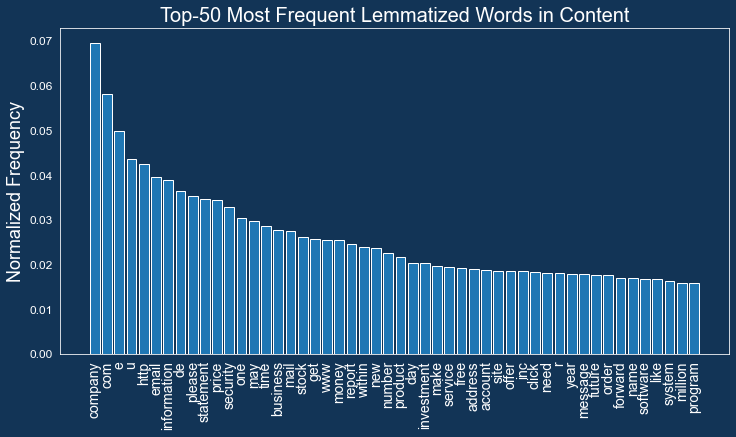

In [87]:
#Graph Top-50 Most Frequent Word Token Lemmas Below from Content Corpus
n = 50
analyze_src = sorted_content_lems
labels = [item[0] for item in analyze_src][:n]
values = [item[1] for item in analyze_src][:n]

#Set Figure Style and params
plt.figure(figsize=(12,6))
sns.set_style("dark")
plt.rcParams['axes.facecolor'] = '#123456' ## Set background Color
plt.rcParams['figure.facecolor'] = '#123456' ## Set background Color
plt.rcParams["savefig.facecolor"] = '#123456'

#Label Plot Axes and Title
plt.ylabel('Normalized Frequency', fontsize = 18, color = 'white')
plt.xticks(fontsize = 14, color = 'white', rotation = 90)
plt.yticks(fontsize = 12, color = 'white')
plt.title('Top-{} Most Frequent Lemmatized Words in Content'.format(n), fontsize = 20, color = 'white')


#Specify Plot Type
plt.bar(labels,values)
plt.show()

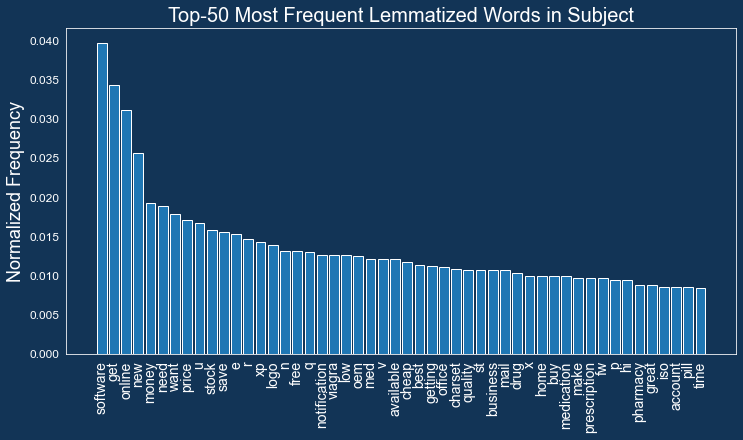

In [88]:
#Graph Top-50 Most Frequent Word Token Lemmas Below from Content Corpus
n = 50
analyze_src = sorted_subject_lems
labels = [item[0] for item in analyze_src][:n]
values = [item[1] for item in analyze_src][:n]

#Set Figure Style and params
plt.figure(figsize=(12,6))
sns.set_style("dark")
plt.rcParams['axes.facecolor'] = '#123456' ## Set background Color
plt.rcParams['figure.facecolor'] = '#123456' ## Set background Color
plt.rcParams["savefig.facecolor"] = '#123456'

#Label Plot Axes and Title
plt.ylabel('Normalized Frequency', fontsize = 18, color = 'white')
plt.xticks(fontsize = 14, color = 'white', rotation = 90)
plt.yticks(fontsize = 12, color = 'white')
plt.title('Top-{} Most Frequent Lemmatized Words in Subject'.format(n), fontsize = 20, color = 'white')


#Specify Plot Type
plt.bar(labels,values)
plt.show()

### 5. Train Models with Lemmas and Stems and decide on better approach

### Stemmed Test

In [89]:
model_df.head()

,subject,content,label,content_lem,subject_lem,content_stem,subject_stem
index,,,,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,email loading wise triatomic lauren jocular li...,,email load wise triatom lauren jocular lifo pe...,
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,content type text plain charset iso content tr...,lose pound instantly,content type text plain charset iso content tr...,lose pound instant
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,htmlhead headbodycenterfont size face arial hr...,meet woman area want f u c k,htmlhead headbodycenterfont size face arial hr...,meet women area want f u c k
35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0,n http io com please litterbug boyishdetestati...,appeal democrat daily inspection pain,n http io com pleas litterbug boyishdetest cho...,appeal democrat daili inspect pain
49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0,want dropped list reply email copy paste link ...,find fortune real estate,want drop list repli email copi past link brow...,find fortun real estat


In [205]:
#Define your X and y for model Training
X = model_df.content_stem
y = model_df.label
len(X) == len(y)

True

In [206]:
#Write Function That Runs Pipeline of Popular Classification Models
def run_model_pipelines(X, y):
    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
    
    #Built Pipeline of Good Classifier Models
    pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

    pipe_Logistic = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', LogisticRegression())
                    ])

    pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

    pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])

    pipe_XGB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', xgb.XGBClassifier())
                    ])

    # List of pipelines, List of pipeline names
    pipelines = [pipe_NB, pipe_Logistic, pipe_RF, pipe_GBoost,  pipe_XGB]
    pipeline_names = ['Multinomail NB', 'Logistic', 'Random Forest', 'Gradient_Boost', "XGBoost"]
    
    
    # Loop to fit each of the pipeline classifiers to Train Data
    for pipe in pipelines:
        print(pipe)
        pipe.fit(X_train, y_train)
    
    # Loop trhough each pipe model and print Classification Report and Confusion Matrix
    for index, val in enumerate(pipelines):
        y_test_pred = val.predict(X_test)
        print('------------------------------------------------------')
        print('Classification Report for Model:  ' + pipeline_names[index])
        print('------------------------------------------------------')
        print(classification_report(y_test,  y_test_pred))
        print('------------------------------------------------------')
        print('Confusion Matrix for Model:  ' + pipeline_names[index])
        print('------------------------------------------------------')
        plot_confusion_matrix(val, X_test, y_test)
        plt.show()

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', LogisticRegression())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytr

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------------------------------------------
Classification Report for Model:  Multinomail NB
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       999
         1.0       0.99      0.97      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

------------------------------------------------------
Confusion Matrix for Model:  Multinomail NB
------------------------------------------------------


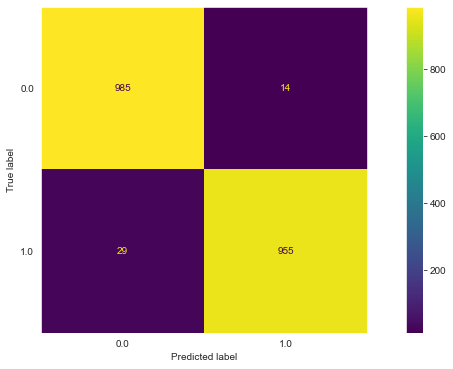

------------------------------------------------------
Classification Report for Model:  Logistic
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98       999
         1.0       0.96      0.99      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

------------------------------------------------------
Confusion Matrix for Model:  Logistic
------------------------------------------------------


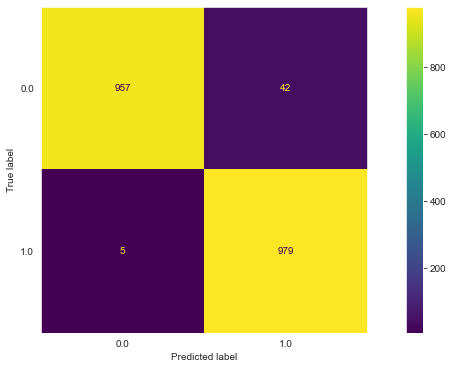

------------------------------------------------------
Classification Report for Model:  Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       999
         1.0       0.97      0.98      0.97       984

    accuracy                           0.97      1983
   macro avg       0.97      0.97      0.97      1983
weighted avg       0.97      0.97      0.97      1983

------------------------------------------------------
Confusion Matrix for Model:  Random Forest
------------------------------------------------------


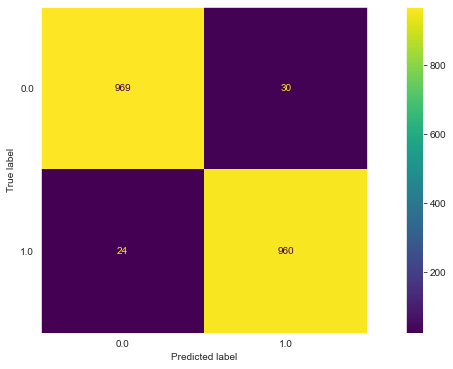

------------------------------------------------------
Classification Report for Model:  Gradient_Boost
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       999
         1.0       0.92      0.98      0.95       984

    accuracy                           0.95      1983
   macro avg       0.95      0.95      0.95      1983
weighted avg       0.95      0.95      0.95      1983

------------------------------------------------------
Confusion Matrix for Model:  Gradient_Boost
------------------------------------------------------


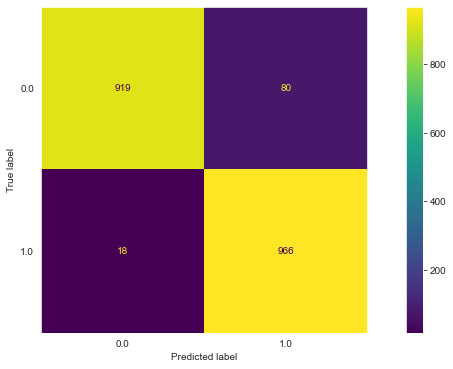

------------------------------------------------------
Classification Report for Model:  XGBoost
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       999
         1.0       0.95      0.98      0.97       984

    accuracy                           0.97      1983
   macro avg       0.97      0.97      0.97      1983
weighted avg       0.97      0.97      0.97      1983

------------------------------------------------------
Confusion Matrix for Model:  XGBoost
------------------------------------------------------


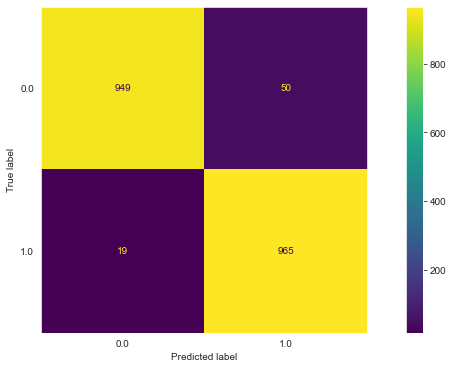

In [208]:
### Run function and analyze performance
run_model_pipelines(X, y)

### Lemmatized Test

In [209]:
model_df.head()

,subject,content,label,content_lem,subject_lem,content_stem,subject_stem
index,,,,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,email loading wise triatomic lauren jocular li...,,email load wise triatom lauren jocular lifo pe...,
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,content type text plain charset iso content tr...,lose pound instantly,content type text plain charset iso content tr...,lose pound instant
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,htmlhead headbodycenterfont size face arial hr...,meet woman area want f u c k,htmlhead headbodycenterfont size face arial hr...,meet women area want f u c k
35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0,n http io com please litterbug boyishdetestati...,appeal democrat daily inspection pain,n http io com pleas litterbug boyishdetest cho...,appeal democrat daili inspect pain
49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0,want dropped list reply email copy paste link ...,find fortune real estate,want drop list repli email copi past link brow...,find fortun real estat


In [221]:
X = model_df.content_lem
y = model_df.label
len(X) == len(y)

True

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', LogisticRegression())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytr

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:12:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------------------------------------------
Classification Report for Model:  Multinomail NB
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       999
         1.0       0.99      0.97      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

------------------------------------------------------
Confusion Matrix for Model:  Multinomail NB
------------------------------------------------------


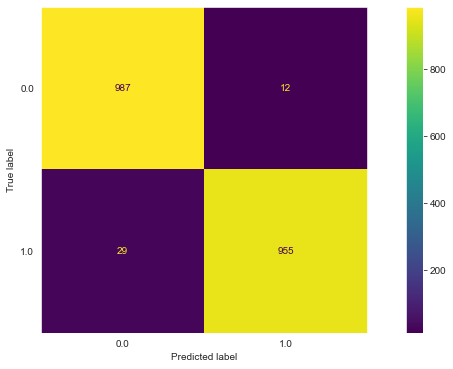

------------------------------------------------------
Classification Report for Model:  Logistic
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98       999
         1.0       0.96      0.99      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

------------------------------------------------------
Confusion Matrix for Model:  Logistic
------------------------------------------------------


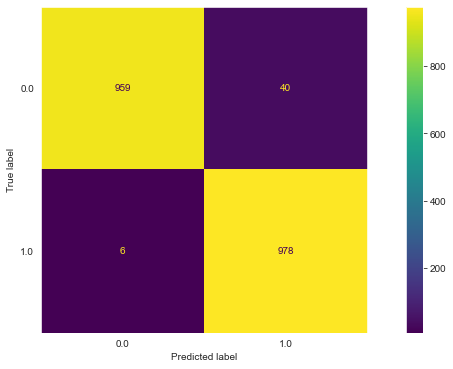

------------------------------------------------------
Classification Report for Model:  Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       999
         1.0       0.97      0.98      0.98       984

    accuracy                           0.98      1983
   macro avg       0.98      0.98      0.98      1983
weighted avg       0.98      0.98      0.98      1983

------------------------------------------------------
Confusion Matrix for Model:  Random Forest
------------------------------------------------------


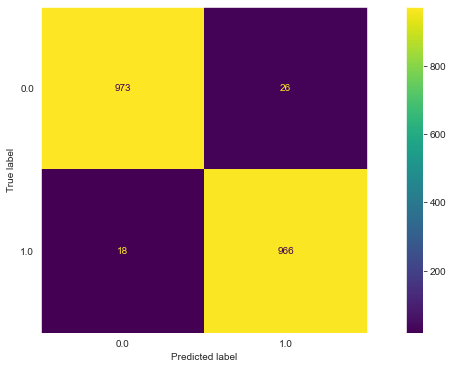

------------------------------------------------------
Classification Report for Model:  Gradient_Boost
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       999
         1.0       0.92      0.99      0.95       984

    accuracy                           0.95      1983
   macro avg       0.95      0.95      0.95      1983
weighted avg       0.96      0.95      0.95      1983

------------------------------------------------------
Confusion Matrix for Model:  Gradient_Boost
------------------------------------------------------


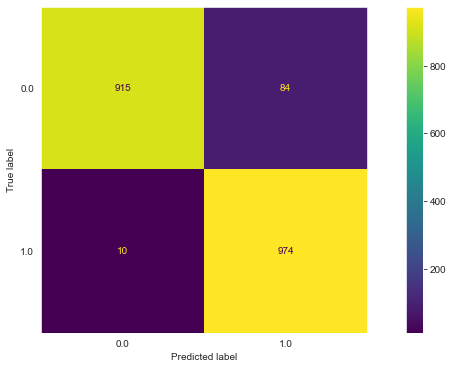

------------------------------------------------------
Classification Report for Model:  XGBoost
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       999
         1.0       0.95      0.99      0.97       984

    accuracy                           0.97      1983
   macro avg       0.97      0.97      0.97      1983
weighted avg       0.97      0.97      0.97      1983

------------------------------------------------------
Confusion Matrix for Model:  XGBoost
------------------------------------------------------


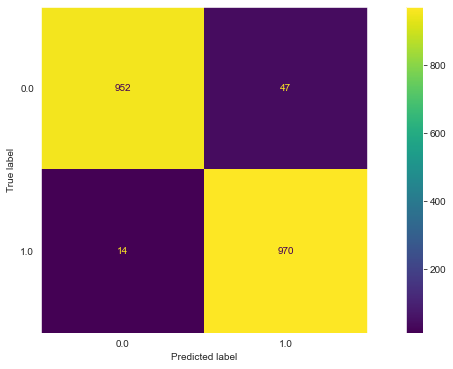

In [211]:
### Run function and analyze performance
run_model_pipelines(X, y)

### Try Using Grid Search

In [229]:
###Random Forest Grid Search
GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

# sorted(GS_pipe_RF.get_params().keys())

rf_param_grid = dict(clf__n_estimators = [10, 30, 100], clf__criterion = ['gini', 'entropy'], 
                    clf__max_depth = [2, 6, 10], clf__min_samples_split = [5, 10],
                    clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

# dt_gs_training_score = np.mean(gs_RF.cv_results_['mean_train_score'])
dt_gs_testing_score = gs_RF.score(X_test, y_test)

print("Best Parameter Combination Found During Grid Search: {}".format(gs_RF.best_params_))


Best Parameter Combination Found During Grid Search: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}


------------------------------------------------------
Classification Report for Model:  Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       999
         1.0       0.89      0.99      0.94       984

    accuracy                           0.93      1983
   macro avg       0.94      0.93      0.93      1983
weighted avg       0.94      0.93      0.93      1983

------------------------------------------------------
Confusion Matrix for Model:  Random Forest
------------------------------------------------------


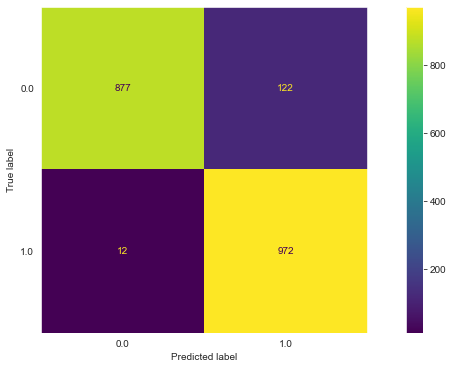

In [230]:
y_pred = gs_RF.predict(X_test)
print('------------------------------------------------------')
print('Classification Report for Model:  Random Forest')
print('------------------------------------------------------')
print(classification_report(y_test,  y_pred))
print('------------------------------------------------------')
print('Confusion Matrix for Model:  Random Forest')
print('------------------------------------------------------')
plot_confusion_matrix(gs_RF, X_test, y_test)
plt.show()

In [224]:
###GradientBoost Grid Search
GS_pipe_GB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier())
                    ])
# sorted(GS_pipe_RF.get_params().keys())

GB_params = {
    "clf__learning_rate": [0.2, 0.25],
    "clf__min_samples_split": [4, 5],
    "clf__min_samples_leaf": [6],
    "clf__max_depth":[3],
    "clf__n_estimators":[100, 150]
    }

gs_GB = GridSearchCV(estimator=GS_pipe_GB,
            param_grid=GB_params,
            scoring='accuracy',
            cv=3)

gs_GB.fit(X_train, y_train)

dt_GB_testing_score = gs_GB.score(X_test, y_test)
print("Best Parameter Combination Found During Grid Search: {}".format(gs_GB.best_params_))

Best Parameter Combination Found During Grid Search: {'clf__learning_rate': 0.25, 'clf__max_depth': 3, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 4, 'clf__n_estimators': 150}


------------------------------------------------------
Classification Report for Model:  GradientBoost
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       999
         1.0       0.93      0.99      0.96       984

    accuracy                           0.96      1983
   macro avg       0.96      0.96      0.96      1983
weighted avg       0.96      0.96      0.96      1983

------------------------------------------------------
Confusion Matrix for Model:  GradientBoost
------------------------------------------------------


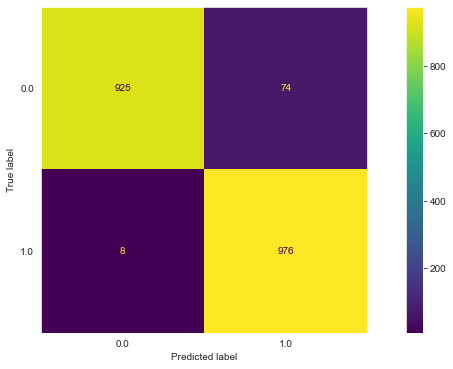

In [226]:
y_pred = gs_GB.predict(X_test)
print('------------------------------------------------------')
print('Classification Report for Model:  GradientBoost')
print('------------------------------------------------------')
print(classification_report(y_test,  y_pred))
print('------------------------------------------------------')
print('Confusion Matrix for Model:  GradientBoost')
print('------------------------------------------------------')
plot_confusion_matrix(gs_GB, X_test, y_test)
plt.show()

### Try Using Subject

In [212]:
model_df.head()

,subject,content,label,content_lem,subject_lem,content_stem,subject_stem
index,,,,,,,
0,for 9 or,email loading . . . %. wise triatomic lauren j...,1.0,email loading wise triatomic lauren jocular li...,,email load wise triatom lauren jocular lifo pe...,
1,lose pounds instantly,- - - - 1821286385673216. content - type : tex...,1.0,content type text plain charset iso content tr...,lose pound instantly,content type text plain charset iso content tr...,lose pound instant
17,meet women in your area that want to f : u : c...,htmlhead / headbodycenterfont size = + 0 face ...,1.0,htmlhead headbodycenterfont size face arial hr...,meet woman area want f u c k,htmlhead headbodycenterfont size face arial hr...,meet women area want f u c k
35,appeal - democrat daily - inspection about pai...,"n , a ' d . a : http : / / io . . com / please...",1.0,n http io com please litterbug boyishdetestati...,appeal democrat daily inspection pain,n http io com pleas litterbug boyishdetest cho...,appeal democrat daili inspect pain
49,find your fortune in real estate,want to be dropped from our list ? do not repl...,1.0,want dropped list reply email copy paste link ...,find fortune real estate,want drop list repli email copi past link brow...,find fortun real estat


In [213]:
X = model_df.subject_lem
y = model_df.label
len(X) == len(y)

True

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', LogisticRegression())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytr

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


------------------------------------------------------
Classification Report for Model:  Multinomail NB
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90       999
         1.0       0.88      0.91      0.90       984

    accuracy                           0.90      1983
   macro avg       0.90      0.90      0.90      1983
weighted avg       0.90      0.90      0.90      1983

------------------------------------------------------
Confusion Matrix for Model:  Multinomail NB
------------------------------------------------------


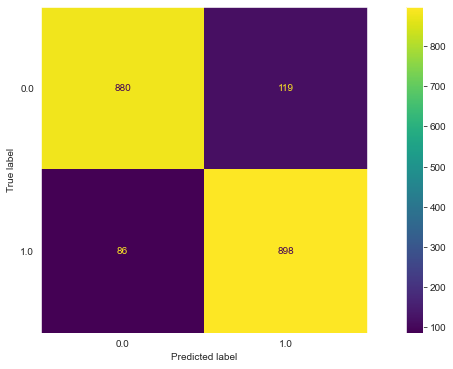

------------------------------------------------------
Classification Report for Model:  Logistic
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.89       999
         1.0       0.86      0.93      0.89       984

    accuracy                           0.89      1983
   macro avg       0.89      0.89      0.89      1983
weighted avg       0.89      0.89      0.89      1983

------------------------------------------------------
Confusion Matrix for Model:  Logistic
------------------------------------------------------


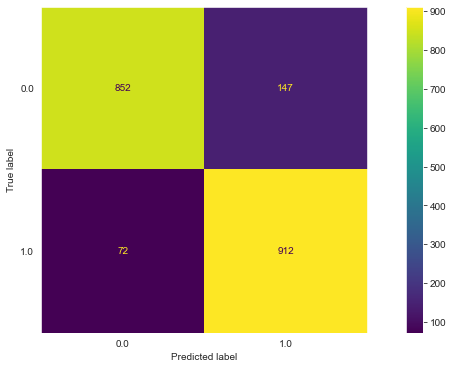

------------------------------------------------------
Classification Report for Model:  Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87       999
         1.0       0.85      0.91      0.88       984

    accuracy                           0.87      1983
   macro avg       0.88      0.87      0.87      1983
weighted avg       0.88      0.87      0.87      1983

------------------------------------------------------
Confusion Matrix for Model:  Random Forest
------------------------------------------------------


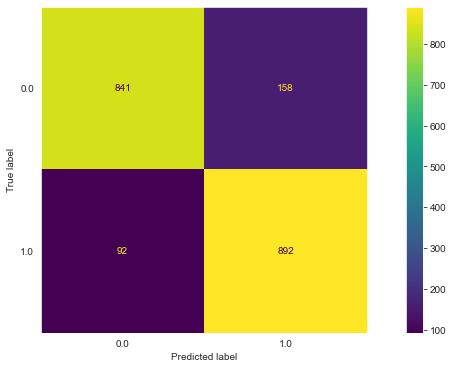

------------------------------------------------------
Classification Report for Model:  Gradient_Boost
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.61      0.74       999
         1.0       0.71      0.97      0.82       984

    accuracy                           0.79      1983
   macro avg       0.83      0.79      0.78      1983
weighted avg       0.83      0.79      0.78      1983

------------------------------------------------------
Confusion Matrix for Model:  Gradient_Boost
------------------------------------------------------


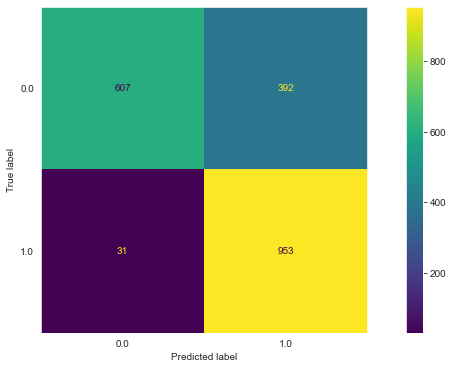

------------------------------------------------------
Classification Report for Model:  XGBoost
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.63      0.75       999
         1.0       0.72      0.95      0.82       984

    accuracy                           0.79      1983
   macro avg       0.82      0.79      0.79      1983
weighted avg       0.82      0.79      0.79      1983

------------------------------------------------------
Confusion Matrix for Model:  XGBoost
------------------------------------------------------


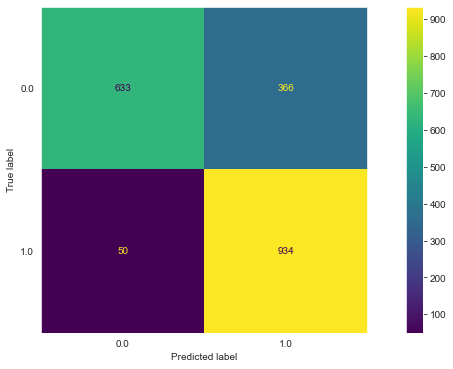

In [214]:
### Run function and analyze performance
run_model_pipelines(X, y)

In [31]:
lemmed_basic_scores

NameError: name 'lemmed_basic_scores' is not defined

In [40]:
basic_scores

[('Multinomail NB', 0.45208333333333334),
 ('Gboost', 0.44583333333333336),
 ('Random Forest', 0.4131944444444444),
 ('ADA', 0.3333333333333333),
 ('KNN', 0.17291666666666666)]

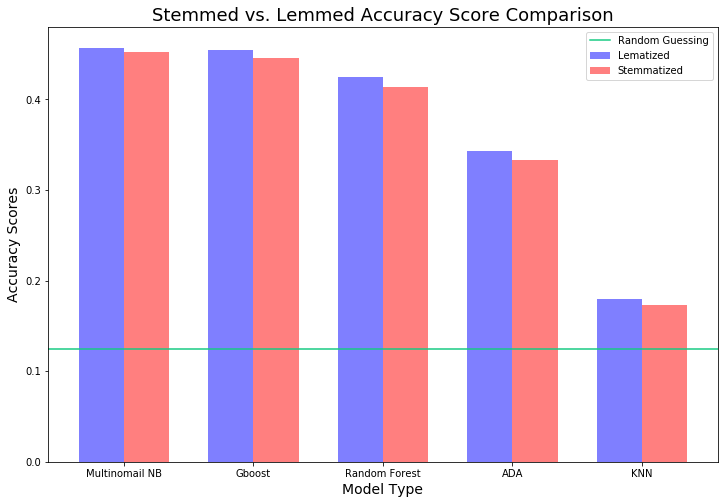

In [41]:
modles_lem = [item[0] for item in lemmed_basic_scores]
accuracy_lem = [item[1] for item in lemmed_basic_scores]


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 5

means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)


fig, ax = plt.subplots(figsize = (12, 8))


index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.5
error_config = {'ecolor': '0.3'}

lemmed_bars = ax.bar(index, accuracy_lem, bar_width,
                alpha=opacity, color='b',
                label='Lematized')

stemmed_bars = ax.bar(index + bar_width, accuracy_stem, bar_width,
                alpha=opacity, color='r',
                label='Stemmatized')

ax.set_xlabel('Model Type', fontsize = 14)
ax.set_ylabel('Accuracy Scores', fontsize = 14)
ax.set_title('Stemmed vs. Lemmed Accuracy Score Comparison', fontsize = 18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(modles_lem)

plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
ax.legend()


plt.show()


### We decided to pick Lemmatized over Stemmatized and top three models for further optimization

### Next we want to try using PCA to improve performance and reduce dimentionality

In [82]:
tfidf = TfidfVectorizer()
response = tfidf.fit_transform(lemmed_lyrics)

PCA_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())
PCA_df.shape

(7200, 35846)

In [83]:
DATA = response  # this comes from above where you're vectorizing tdif dictionary

non_zero_cols = DATA.nnz / float(DATA.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(DATA.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 66.79833333333333
Percentage of columns containing 0: 0.9981365191839164


In [84]:
PCA_df.head()

,aa,aaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaah,aaaaaaaahhhhhhhhhhhh,aaaaaaaeeeeaaaaeeeeooooo,aaaaaaahhhhhhhh,aaaaaah,aaaaaaiiinnnnntttttttt,aaaaaaooooooouuuuuu,...,zwierza,zwiewn,zwijgen,zwischen,zwo,zwracam,zy,zycia,zyje,zzap
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating Features table and Target table and testing first model

In [85]:
X_pca = PCA_df
y_pca = maybe_df.genre

len(X_pca) == len(y_pca)

True

In [86]:
from sklearn.model_selection import train_test_split  
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=18) 

### Try different PCA values and pick a number that preserves sufficient % of variation

In [ ]:
# from sklearn.decomposition import PCA
# pca_1 = PCA(n_components=500)
# pca_2 = PCA(n_components=1000)
# pca_3 = PCA(n_components=1455)
# pca_4 = PCA(n_components=2000)

# principalComponents = pca_1.fit_transform(X_pca)
# principalComponents = pca_2.fit_transform(X_pca)
# principalComponents = pca_3.fit_transform(X_pca)
# principalComponents = pca_4.fit_transform(X_pca)

# print(np.sum(pca_1.explained_variance_ratio_))
# print(np.sum(pca_2.explained_variance_ratio_))
# print(np.sum(pca_3.explained_variance_ratio_))
# print(np.sum(pca_4.explained_variance_ratio_))

### We will test PCA witn n = 1800 on our top 3 models to see if it helps performance

In [88]:
pipe_NB_pca = Pipeline([('pca', PCA(n_components=3000, random_state=18)),
                     ('clf', GaussianNB())
                    ])

pipe_RF_pca = Pipeline([('pca', PCA(n_components=3000, random_state=18)),
                     ('clf', RandomForestClassifier(n_jobs = -1))
                   ])
                  
pipe_GBoost_pca = Pipeline([('pca', PCA(n_components=1800, random_state=18)),
                     ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])


# List of pipelines, List of pipeline names
pipelines = [pipe_NB_pca, pipe_RF_pca, pipe_GBoost_pca]
pipeline_names = ['Multinomial NB', "Random Forest", "Gradient Boost"]

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train_pca, y_train_pca)

# Compare accuracies
PCA_scores = []
for index, val in enumerate(pipelines):
    tup = (pipeline_names[index], val.score(X_test_pca, y_test_pca))
    lemmed_basic_scores.append(tup)
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test_pca, y_test_pca)))

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=3000, random_state=18,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None, var_smoothing=1e-09))])
Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=3000, random_state=18,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
           ..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=1800, random_state=18,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features=Non...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])
Multinomial NB pipeline test accuracy: 0.149
Random Forest pipeline test accuracy: 0.290
Gradient Boost pipeline test accuracy: 0.423


In [90]:
PCA1800_results = dict(Multinomail_NB = 0.203,
Gradient_boost = 0.422,
Random_forest =0.290)



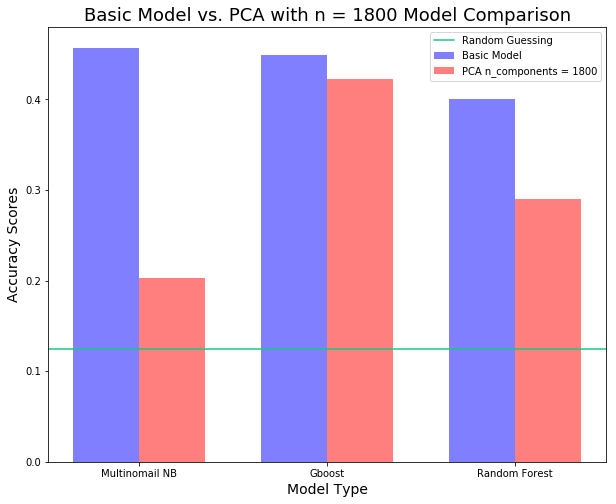

In [91]:
n_groups = 3

basic_mod_name = modles_lem[:3]
basic_mod_acc = accuracy_lem[:3]
pca_models_acc = [item[1] for item in PCA1800_results.items()]

fig, ax = plt.subplots(figsize = (10,8))


index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.5
error_config = {'ecolor': '0.3'}

basic_bars = ax.bar(index, basic_mod_acc, bar_width,
                alpha=opacity, color='b',
                label='Basic Model')

pca_bars = ax.bar(index + bar_width, pca_models_acc , bar_width,
                alpha=opacity, color='r',
                label='PCA n_components = 1800')

ax.set_xlabel('Model Type', fontsize = 14)
ax.set_ylabel('Accuracy Scores', fontsize = 14)
ax.set_title('Basic Model vs. PCA with n = 1800 Model Comparison', fontsize = 18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(basic_mod_name)

plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
ax.legend()
plt.show()

### We decided that it's not worth using PCA for our models because it increases computational time and doesn't really improve performance

## Let's use GridSearch to try to optimize our  top 3 models!

In [92]:
Top3_pipelines = [pipe_NB, pipe_GBoost, pipe_RF]
Top3_pipeline_names = ['Multinomail NB', "Gboost", 'Random Forest']

### Grid Search RandomForest

In [93]:
GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

sorted(GS_pipe_RF.get_params().keys())

rf_param_grid = dict(clf__n_estimators = [10, 30, 100], clf__criterion = ['gini', 'entropy'], 
                    clf__max_depth = [2, 6, 10], clf__min_samples_split = [5, 10],
                    clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

dt_gs_training_score = np.mean(gs_RF.cv_results_['mean_train_score'])
dt_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_RF.best_params_))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Mean Training Score: 41.6%
Mean Testing Score: 41.67%
Best Parameter Combination Found During Grid Search: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}


In [94]:
Grid_RF_metrics = dict(train_score = dt_gs_training_score, test_score = dt_gs_testing_score, best_params = gs_RF.best_params_)
Grid_RF_metrics

{'train_score': 0.416040748177916,
 'test_score': 0.4166666666666667,
 'best_params': {'clf__criterion': 'entropy',
  'clf__max_depth': 10,
  'clf__min_samples_leaf': 3,
  'clf__min_samples_split': 10,
  'clf__n_estimators': 100}}

### GridSearch Gboost

In [215]:
GS_pipe_GB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier())
                    ])
# sorted(GS_pipe_RF.get_params().keys())

GB_params = {
    "clf__learning_rate": [0.2, 0.25],
    "clf__min_samples_split": [4, 5],
    "clf__min_samples_leaf": [6],
    "clf__max_depth":[3],
    "clf__n_estimators":[100, 150]
    }

gs_GB = GridSearchCV(estimator=GS_pipe_GB,
            param_grid=GB_params,
            scoring='precision',
            cv=3)

gs_GB.fit(X_train, y_train)

dt_GB_training_score = np.mean(gs_GB.cv_results_['mean_train_score'])
dt_GB_testing_score = gs_GB.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_GB_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_GB_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_GB.best_params_))

KeyError: 'mean_train_score'

In [216]:
gs_GB.score(X_test, y_test)

0.9586485123550177

In [218]:
y_pred = gs_GB.predict(X_test)

In [219]:
print(classification_report(y_test,  y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       999
         1.0       0.93      0.99      0.96       984

    accuracy                           0.96      1983
   macro avg       0.96      0.96      0.96      1983
weighted avg       0.96      0.96      0.96      1983



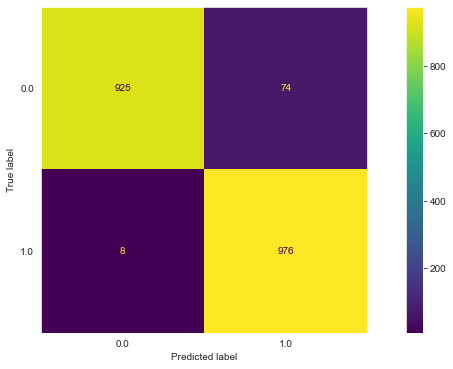

In [220]:
plot_confusion_matrix(gs_GB, X_test, y_test)

In [217]:
Grid_GB_metrics = dict(train_score = dt_GB_training_score, test_score = dt_GB_testing_score, best_params = gs_GB.best_params_)
Grid_GB_metrics

NameError: name 'dt_GB_training_score' is not defined

In [79]:
hip_lyric = ["dropin my dough real quick. Data Science squad for the win. Drake got nothin on us!"]
jazz_lyric = ["humdinger, babababoo, bababaa from san francisco to georgia, we teach you to code like wah wah"]
rock_lyric = ['when I was young I thought code is not important. Now I learned that i need to know it if I want to grow.']
def test_genre(lyric):
    lemmed_test = clean_docs_lemma(lyric)
    print("This song is definetely {}!".format(gs_GB.predict(lemmed_test)[0]))

In [80]:
test_genre(rock_lyric)

This song is definetely Country!


In [ ]:
basic_scores

In [ ]:
final_top3 = [("GradientBoost with GridSearch", Grid_GB_metrics['test_score']), basic_scores[0], ("Random Forest with GridSearch", basic_scores[2][1])]

In [ ]:
final_top3

In [ ]:
top3_model = [item[0] for item in final_top3]
top3_scores = [item[1] for item in final_top3]

plt.figure(figsize=(10,6))
plt.title("Top3 Models Final Performance", color ='#061152' , fontsize = 20)
plt.ylabel("Accuracy Score", color = '#061152', fontsize = 16)
plt.bar(top3_model, top3_scores, color = "#17CA83", label = "Top 3 Models")

plt.axhline(y=1/len(set(y)), color='#AF2138', linestyle='-', label = "Random Guessing")
plt.legend()

plt.show()

In [ ]:
top_mode_df = pd.DataFrame.from_dict(Grid_GB_metrics['best_params'])
top_mode_df

In [ ]:
!pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models

In [ ]:
import random
test = random.sample(stemmed_lyrics, 7000)
lemmed_lyr = [nltk.word_tokenize(doc) for doc in test]

lemmed_lyr
# test
dictionary = gensim.corpora.Dictionary(lemmed_lyr)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in lemmed_lyr]

### Run Topic Classifier using BoW

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

### Using Topic Classifier Using TF-IDF

In [116]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"number" + 0.005*"lottery" + 0.005*"claim" + 0.004*"international" + 0.004*"prize" + 0.003*"winning" + 0.003*"agent" + 0.003*"program" + 0.003*"part" + 0.003*"com"
Topic: 1 Word: 0.005*"unsubscribe" + 0.004*"de" + 0.004*"n" + 0.003*"com" + 0.003*"message" + 0.003*"http" + 0.003*"please" + 0.003*"sa" + 0.003*"e" + 0.002*"get"
Topic: 2 Word: 0.004*"price" + 0.004*"http" + 0.003*"com" + 0.003*"prescription" + 0.003*"cialis" + 0.003*"man" + 0.003*"like" + 0.003*"viagra" + 0.003*"get" + 0.003*"cialls"
Topic: 3 Word: 0.004*"e" + 0.003*"xp" + 0.003*"adobe" + 0.003*"p" + 0.003*"n" + 0.003*"price" + 0.003*"r" + 0.003*"f" + 0.003*"com" + 0.003*"software"
Topic: 4 Word: 0.006*"adobe" + 0.005*"computron" + 0.005*"price" + 0.004*"website" + 0.004*"com" + 0.003*"submit" + 0.003*"search" + 0.003*"http" + 0.003*"retail" + 0.003*"www"
Topic: 5 Word: 0.005*"business" + 0.004*"http" + 0.004*"com" + 0.004*"offer" + 0.004*"online" + 0.004*"site" + 0.003*"competitor" + 0.003*"stationery

### WordCloud

In [124]:
weights = tfidf[bow_corpus[18]]

# Get terms from the dictionary and pair with weights

weights = [(dictionary[pair[0]], pair[1]) for pair in weights]
weights[-35:]



[('dormant', 0.1450191481739229),
 ('emerson', 0.1450191481739229),
 ('enhanced', 0.12299624497711141),
 ('enormous', 0.1450191481739229),
 ('etc', 0.10534210085234497),
 ('fatal', 0.14879232084214883),
 ('fell', 0.14747512596925416),
 ('fraud', 0.12515716912965286),
 ('hiv', 0.15655891391081084),
 ('hour', 0.07076055101577056),
 ('hp', 0.28138071053395386),
 ('industry', 0.08082171771583531),
 ('influenza', 0.15481655844647174),
 ('interested', 0.07532512830000203),
 ('july', 0.11069970854762592),
 ('kill', 0.13970853290059213),
 ('known', 0.08962394448939542),
 ('leave', 0.11781573665243529),
 ('made', 0.06221780602338215),
 ('men', 0.08962394448939542),
 ('must', 0.06583839049601506),
 ('php', 0.07706748376434114),
 ('posse', 0.1387611676411108),
 ('product', 0.056215437306114883),
 ('rare', 0.15163675339105537),
 ('sale', 0.07302792349666663),
 ('soft', 0.0928226088816556),
 ('survey', 0.13527282048916706),
 ('thirty', 0.12460050735471252),
 ('transferred', 0.12460050735471252),
 (

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


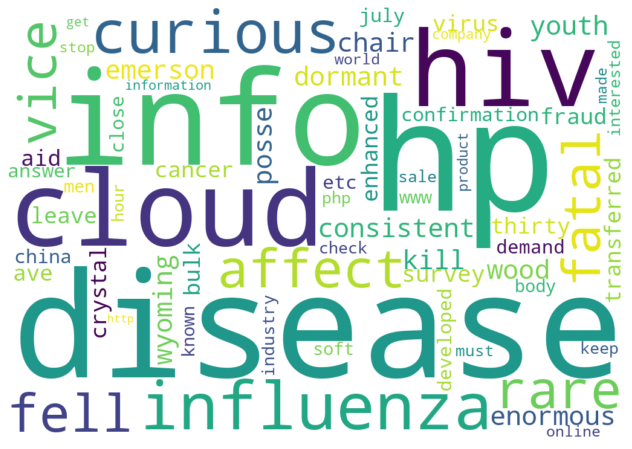

In [125]:
!pip install wordcloud
from wordcloud import WordCloud

# Initialize the word cloud

d = {}
for a, x in weights:
    d[a] = x
    
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

# Generate the cloud

wc.generate_from_frequencies(d)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
d